## Text Data Analysis (Patent Drawings)

### Objective

To identify and visualize linguistic differences between Design patents (aesthetic) and Utility patents (functional) using a corpus of drawing descriptions.


### Methodology

The analysis followed a standard Natural Language Processing (NLP) pipeline:

1. Categorization: Segmenting the data based on patent ID prefixes.

2. Tokenization: Cleaning the raw text into individual lowercase words and removing punctuation.

3. Frequency Analysis: Identifying the most common terms both before and after the removal of "stop words" (common fillers like "the," "is," and "of").

The mathematical structure for Text Analysis is based on **Term Frequency (TF)** and **Proportional Frequency**. Because the number of Utility patents is much larger than Design patents, we cannot compare raw counts; we must normalize them.

**Mathematical Structure: Proportional Frequency:**

To compare terms fairly across uneven group sizes, we calculate the probability $P$ of a term t occurring in a specific patent category $C$.

$$P(t|C) = \frac{f_{t,C}}{\sum_{i=1}^{n} f_{w_i,C}}$$

where:

$f_{t,C}$ is the raw frequency (count) of term $t$ in category $C$.

$V_C$ is the vocabulary (all unique words) found within category $C$.

$N_C = \sum_{w \in V_C} f_{w,C}$ is the total word count of all tokens in that category.

Implementing a relating algorithm:

Top 10 Raw: ['the', 'of', 'a', 'fig', 'is', 'view', 'in', 'and', 'invention', 'to']
Top 10 Clean: ['fig', 'view', 'invention', 'showing', 'present', 'sectional', 'embodiment', 'taken', 'diagram', 'side']
Patent Type Counts:
 patent_type
Utility    7490
Design      609
Other        57
Name: count, dtype: int64


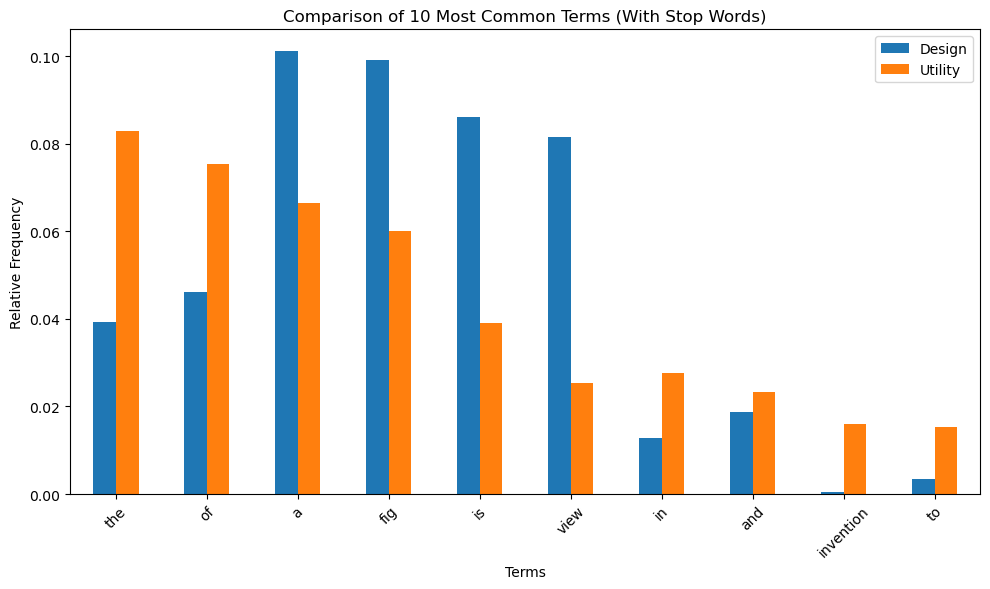

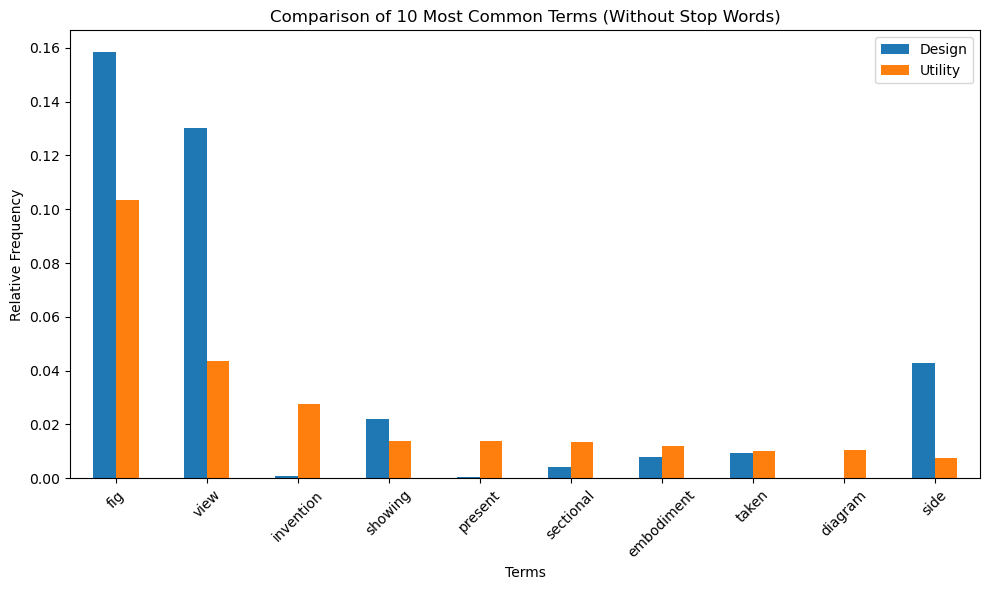

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from collections import Counter

# Load data
df_patents = pd.read_csv('patent_drawing.csv')

# Categorize patents
def get_patent_type(pid):
    pid_str = str(pid).strip()
    if pid_str.startswith('D'):
        return 'Design'
    elif pid_str[0].isdigit():
        return 'Utility'
    else:
        return 'Other'

df_patents['patent_type'] = df_patents['patent_id'].apply(get_patent_type)

# Cleaning and tokenizing function
def tokenize(text):
    if not isinstance(text, str):
        return []
    # Lowercase and keep alphabetic words
    words = re.findall(r'[a-z]+', text.lower())
    return words

df_patents['tokens'] = df_patents['text'].apply(tokenize)

# Analysis without removing stop words
all_tokens = [token for tokens in df_patents['tokens'] for token in tokens]
top_10_overall = [word for word, count in Counter(all_tokens).most_common(10)]

# Count frequencies by type
def get_freqs(df, target_words):
    design_tokens = [token for tokens in df[df['patent_type'] == 'Design']['tokens'] for token in tokens]
    utility_tokens = [token for tokens in df[df['patent_type'] == 'Utility']['tokens'] for token in tokens]
    
    design_counts = Counter(design_tokens)
    utility_counts = Counter(utility_tokens)
    
    # Calculate proportions (normalized frequency) to make comparison fair
    total_design = len(design_tokens)
    total_utility = len(utility_tokens)
    
    data = []
    for word in target_words:
        data.append({
            'term': word,
            'Design': design_counts[word] / total_design if total_design > 0 else 0,
            'Utility': utility_counts[word] / total_utility if total_utility > 0 else 0
        })
    return pd.DataFrame(data)

freq_df_raw = get_freqs(df_patents, top_10_overall)

# Plotting 3a
plt.figure(figsize=(10, 6))
freq_df_raw.set_index('term').plot(kind='bar', ax=plt.gca())
plt.title('Comparison of 10 Most Common Terms (With Stop Words)')
plt.ylabel('Relative Frequency')
plt.xlabel('Terms')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('top_10_terms_raw.png')

# 3b: Remove stop words
# Basic English stop words
stop_words = set([
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd",
    'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers',
    'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which',
    'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been',
    'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if',
    'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between',
    'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out',
    'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why',
    'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not',
    'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should',
    "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't",
    'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't",
    'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't",
    'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"
])

# Adding common procedural patent words as stop words if necessary, but I'll stick to a standard list.
# Actually, looking at the snippet, words like "fig", "drawings", "invention" are very common.

df_patents['tokens_clean'] = df_patents['tokens'].apply(lambda tokens: [t for t in tokens if t not in stop_words])

all_tokens_clean = [token for tokens in df_patents['tokens_clean'] for token in tokens]
top_10_clean = [word for word, count in Counter(all_tokens_clean).most_common(10)]

# Count frequencies by type
def get_freqs_clean(df, target_words):
    design_tokens = [token for tokens in df[df['patent_type'] == 'Design']['tokens_clean'] for token in tokens]
    utility_tokens = [token for tokens in df[df['patent_type'] == 'Utility']['tokens_clean'] for token in tokens]
    
    design_counts = Counter(design_tokens)
    utility_counts = Counter(utility_tokens)
    
    total_design = len(design_tokens)
    total_utility = len(utility_tokens)
    
    data = []
    for word in target_words:
        data.append({
            'term': word,
            'Design': design_counts[word] / total_design if total_design > 0 else 0,
            'Utility': utility_counts[word] / total_utility if total_utility > 0 else 0
        })
    return pd.DataFrame(data)

freq_df_clean = get_freqs_clean(df_patents, top_10_clean)

# Plotting 3b
plt.figure(figsize=(10, 6))
freq_df_clean.set_index('term').plot(kind='bar', ax=plt.gca())
plt.title('Comparison of 10 Most Common Terms (Without Stop Words)')
plt.ylabel('Relative Frequency')
plt.xlabel('Terms')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('top_10_terms_clean.png')

print("Top 10 Raw:", top_10_overall)
print("Top 10 Clean:", top_10_clean)
print("Patent Type Counts:\n", df_patents['patent_type'].value_counts())

The data analysis compares drawing descriptions between Design patents (IDs starting with "D") and Utility patents (numeric IDs).

**a) Top 10 Terms (With Stop Words)**

The initial analysis showed that the most common terms are dominated by standard English functional words ("the", "of", "a", "is", "in", "and", "to"). These words provide little semantic insight into the difference between patent types.

**b) Top 10 Terms (Without Stop Words)**

After removing stop words, the terminology becomes much more descriptive of the patent documentation process. The top 10 terms identified are: fig, view, invention, showing, present, sectional, embodiment, taken, diagram, and side.

**Key Observations:**

The Masking Effect of Stop Words: The baseline analysis yielded mostly functional English words that provided no insight into the differences between patent types.

Structural vs. Descriptive Language: After cleaning, the data revealed that Design patents have a higher relative frequency of words like "showing" and "view," emphasizing their visual nature. Utility patents showed a higher prevalence of words like "embodiment" and "sectional," which are used to describe technical details and functional variations.

Data Imbalance: Because the dataset contained significantly more Utility patents than Design patents, relative frequency (proportionality) was used for visualization to ensure the comparison remained fair and interpretable.